In [1]:
import os
import shutil
import sqlite3
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import unique
from pandas.core.frame import DataFrame
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler

In [3]:
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"

CONFIG

In [4]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
MIN_CLUSTERS_NUMBER = 2
MAX_CLUSTERS_NUMBER = 10
BEST_KMEANS_CLUSTERS_NUMBER = 4

In [6]:
def display_plot(plot, filename: str, prefix: str) -> None:
    # os.makedirs(f"plots/{prefix}", exist_ok=True)

    # fig = plot.get_figure()
    # if hasattr(plot, 'get_figure'):
        # fig = plot.get_figure()
    # elif hasattr(plot, '_figure'):
        # fig = plot._figure
    # else:
        # fig = plot
    # fig.savefig(f"plots/{prefix}/{filename}.png")
    plt.show()
    plt.close()

In [7]:
def load_data(nb_elements=99999999):
    """Load the data from the db, extract the RFM and average review attributes and returns them."""
    con = sqlite3.connect("resources/olist.db")
    con.row_factory = sqlite3.Row
    cur = con.cursor()
    
    res = cur.execute("""SELECT customer_id, customer_unique_id FROM customers 
    where customer_id in (select customer_id from orders)""")
    customers = res.fetchall()
    
    res = cur.execute("select order_id, review_score from order_reviews")
    reviews = res.fetchall()
    
    res = cur.execute(
        """SELECT o.order_id, o.customer_id, o.order_purchase_timestamp, oi.price
    FROM orders o
    inner join order_items oi on o.order_id = oi.order_id""")
    orders = res.fetchall()
    
    cur.close()
    con.close()
    
    sorted_reviews = {}
    for review in reviews:
        sorted_reviews.setdefault(
            review['order_id'],
            []).append(
            review['review_score'])

    sorted_orders = {}
    for order in [dict(order) for order in orders]:
        order['review_score'] = sorted_reviews[order['order_id']
                                               ][0] if order['order_id'] in sorted_reviews else None
        sorted_orders.setdefault(order['customer_id'], []).append(order)

    sorted_customers = {}
    for customer in [dict(customer) for customer in customers]:
        sorted_customers.setdefault(
            customer['customer_unique_id'], []).append(
            customer['customer_id'])
        
    clients = []
    for customer_unique_id in sorted_customers.keys():
        customer_ids = sorted_customers[customer_unique_id]
        
        customer_orders = []
        for customer_id in customer_ids:
            customer_orders += sorted_orders[customer_id] if customer_id in sorted_orders else []
            
        if len(customer_orders) == 0:
            continue
            
        total_amount = sum([order['price'] for order in customer_orders])
        nb_products = len(customer_orders)
        
        order_timestamps = [
            datetime.strptime(
                order['order_purchase_timestamp'],
                DATE_FORMAT) for order in customer_orders]
        latest_purchase_date: datetime = max(order_timestamps)
        days_since_last_purchase = (datetime.now() - latest_purchase_date).days
        
        review_scores = [order['review_score']
                         for order in customer_orders if order['review_score'] is not None]
        if len(review_scores) > 0:
            average_review = sum(review_scores) / len(review_scores)
        else:
            average_review = 0

        # Excluding 71 clients for a better visibility of the clusters
        if nb_products < 8:
            clients.append({
                'average_review': average_review,
                'recency': days_since_last_purchase,
                'frequency': nb_products,
                'monetary_value': total_amount
            })
            
    return DataFrame(clients[:nb_elements])

In [8]:
def fit_kmeans(scaled_features, kmeans_kwargs):
    """Performs multiple Kmeans modelings and returns the SSE and silhouette scores."""
    sse = []
    silhouette_coefficients = []
    for k in range(MIN_CLUSTERS_NUMBER, MAX_CLUSTERS_NUMBER + 1):
        print(
            f"KMeans clustering with {k} cluster{
                's' if k > 1 else ''} started at {
                datetime.now().strftime("%H:%M:%S")}")
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(scaled_features)
        
        visualize_clusters(scaled_df, kmeans.labels_, f"kmeans")
        
        sse.append(kmeans.inertia_)

        score = silhouette_score(scaled_features, kmeans.labels_)
        silhouette_coefficients.append(score)
            
    return sse, silhouette_coefficients

In [9]:
def create_sse_plot(sse):
    """Display the SSE plot."""
    plt.figure(figsize=(10, 9))
    plot = sns.lineplot(
        DataFrame(sse),
        x=range(
            MIN_CLUSTERS_NUMBER,
            MAX_CLUSTERS_NUMBER + 1),
        y=sse)
    plot.set_title("SSE curve")
    plot.set_xlabel("Number of Clusters")
    plot.set_ylabel("SSE")
    display_plot(plot, "elbow", "kmeans")

In [10]:
def create_silhouette_score_plot(silhouette_coefficients):
    """Generate a plot showing the silhouette score per cluster numbers and display it."""
    plt.figure(figsize=(10, 9))
    plot = sns.lineplot(
        DataFrame(silhouette_coefficients),
        x=range(
            MIN_CLUSTERS_NUMBER,
            MAX_CLUSTERS_NUMBER + 1),
        y=silhouette_coefficients)
    plot.set_title("Silhouette Coefficient curve")
    plot.set_xlabel("Number of Clusters")
    plot.set_ylabel("Silhouette Coefficient")
    display_plot(plot, "silhouette_coefficient", "kmeans")

In [11]:
def perform_kmeans_modeling(scaled_df):
    """Performs multiple Kmeans modelings, produces SSE and silhouette score plots
    and returns the best number of clusters based on the elbow method and its labels.
    """
    print("Starting KMEANS modeling.\n")
    
    kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 50,
        "max_iter": 500
    }
    sse, silhouette_coefficients = fit_kmeans(scaled_df, kmeans_kwargs)
    create_sse_plot(sse)
    create_silhouette_score_plot(silhouette_coefficients)

    # kl = KneeLocator(range(MIN_CLUSTERS_NUMBER, MAX_CLUSTERS_NUMBER + 1), sse, curve="convex", direction="decreasing")
    # print(f"\nElbow found at iteration:{kl.elbow}.\n")
    kmeans = KMeans(n_clusters=BEST_KMEANS_CLUSTERS_NUMBER, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    return kmeans.labels_

In [12]:
def perform_hierarchical_modeling(scaled_df):
    """Performs hierarchical modeling."""
    print("Starting hierarchical modeling.\n")
    
    for clusters_number in range(MIN_CLUSTERS_NUMBER, MAX_CLUSTERS_NUMBER + 1):
        hierarchical_cluster = AgglomerativeClustering(n_clusters=clusters_number, metric='euclidean', linkage='ward')
        labels = hierarchical_cluster.fit_predict(scaled_df)
        visualize_clusters(scaled_df, labels, f"hierarchical")
        
    plt.figure(figsize=(15, 15))
    dendrogram(
        linkage(
            scaled_df,
            method="ward",
            metric="euclidean"),
        truncate_mode="level",
        p=6)
    plt.show()

In [13]:
def perform_density_based_modeling(scaled_df):
    """Performs DBSCAN and OPTICS modeling."""
    perform_dbscan_clustering(scaled_df)
    perform_optics_clustering(scaled_df)

In [14]:
def perform_optics_clustering(scaled_df):
    """Performs OPTICS modeling."""
    print("Starting OPTICS modeling.\n")
    
    for min_samples in range(25, 150, 5):
        optics = OPTICS(min_samples=min_samples)
        optics.fit(scaled_df)
        labels = optics.labels_
        
        clusters_number = len(unique(labels))
        if MIN_CLUSTERS_NUMBER <= clusters_number <= MAX_CLUSTERS_NUMBER:
            visualize_clusters(
                scaled_df,
                labels,
                f"optics_min_samples_{min_samples}")

In [15]:
def perform_dbscan_clustering(scaled_df):
    """Performs DBSCAN modeling."""
    print("Starting DBSCAN modeling.\n")
    
    for eps in np.arange(0.01, 2, 0.01):
        dbscan = DBSCAN(eps=eps, min_samples=100)
        dbscan.fit(scaled_df)
        labels = dbscan.labels_
        
        clusters_number = len(unique(labels))
        if MIN_CLUSTERS_NUMBER <= clusters_number <= MAX_CLUSTERS_NUMBER:
            visualize_clusters(
                scaled_df,
                labels,
                f"dbscan_eps_{
                    round(
                        eps,
                        2)}")

In [16]:
def visualize_clusters(scaled_df, labels, strategy_name):
    """Generate a PCA graph showing the generated clusters and display the plot."""
    labels = pd.Categorical(labels)
    
    pca = PCA()
    pca_results = pca.fit_transform(scaled_df)
    pca_df = DataFrame(pca_results[:, :2], columns=['x', 'y'])
    pca_df['labels'] = pd.Categorical(labels)
    
    plt.figure(figsize=(10, 10))
    plot = sns.scatterplot(
        pca_df,
        x='x',
        y='y',
        hue="labels",
        palette="bright")
    
    plot.set_title(
        f'Scatter plot of clusters from strategy {
            strategy_name.upper()}')
    plot.set_xlabel(
        f'F1 ({
            round(
                100 *
                pca.explained_variance_ratio_[0],
                1)}%)')
    plot.set_ylabel(
        f'F2 ({
            round(
                100 *
                pca.explained_variance_ratio_[1],
                1)}%)')
    plot.grid(True)
    
    display_plot(plot,
             f"{strategy_name.replace("_",
                                      " ")}_{len(labels.unique())}_clusters",
             f"{strategy_name.split("_")[0]}")

In [17]:
def verify_form_and_stability_of_best_strategy(scaled_df, original_labels):
    """Performs multiple kmeans modeling with the best clusters number to verify its form and result."""
    print("Starting verification of form and stability of the best strategy.\n")
    
    overall_ari_score = 0.0
    iterations_number = 10
    for iteration in range(1, iterations_number + 1):
        kmeans = KMeans(n_clusters=BEST_KMEANS_CLUSTERS_NUMBER)
        kmeans.fit(scaled_df)
        labels = kmeans.labels_
        
        visualize_clusters(scaled_df, labels, f"final_kmeans_iteration_{iteration}")
        
        ari_score = round(adjusted_rand_score(labels, original_labels), 4)
        overall_ari_score += ari_score
        
    print(
        f"Average ari score:{
            round(
                overall_ari_score /
                iterations_number,
                2)} " f"across {iterations_number} iterations.\n")

Starting modeling script.

Data loaded.

Starting KMEANS modeling.

KMeans clustering with 2 clusters started at 13:31:45


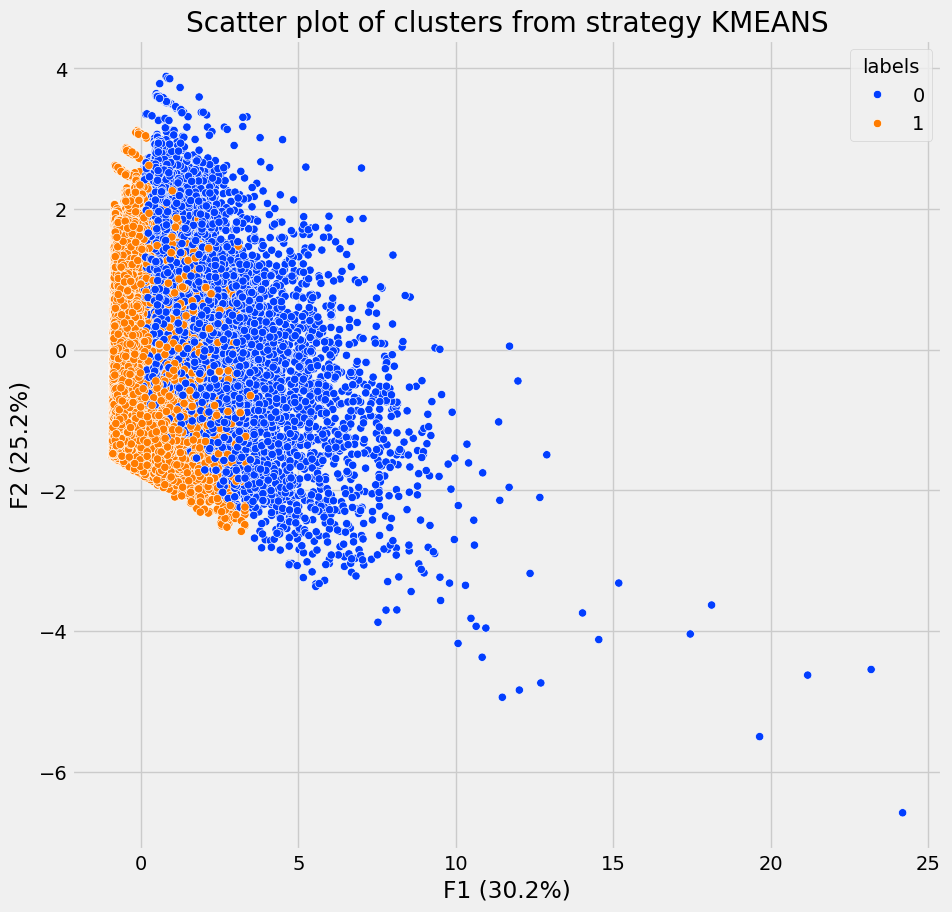

KMeans clustering with 3 clusters started at 13:33:42


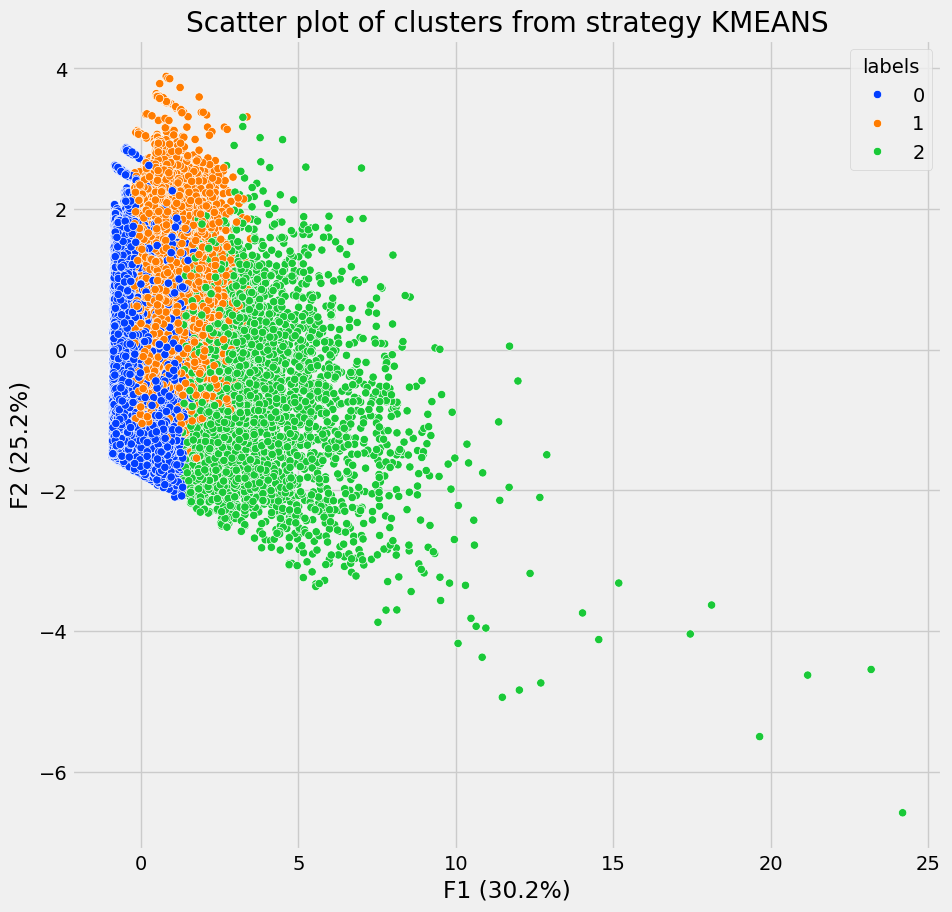

KMeans clustering with 4 clusters started at 13:35:37


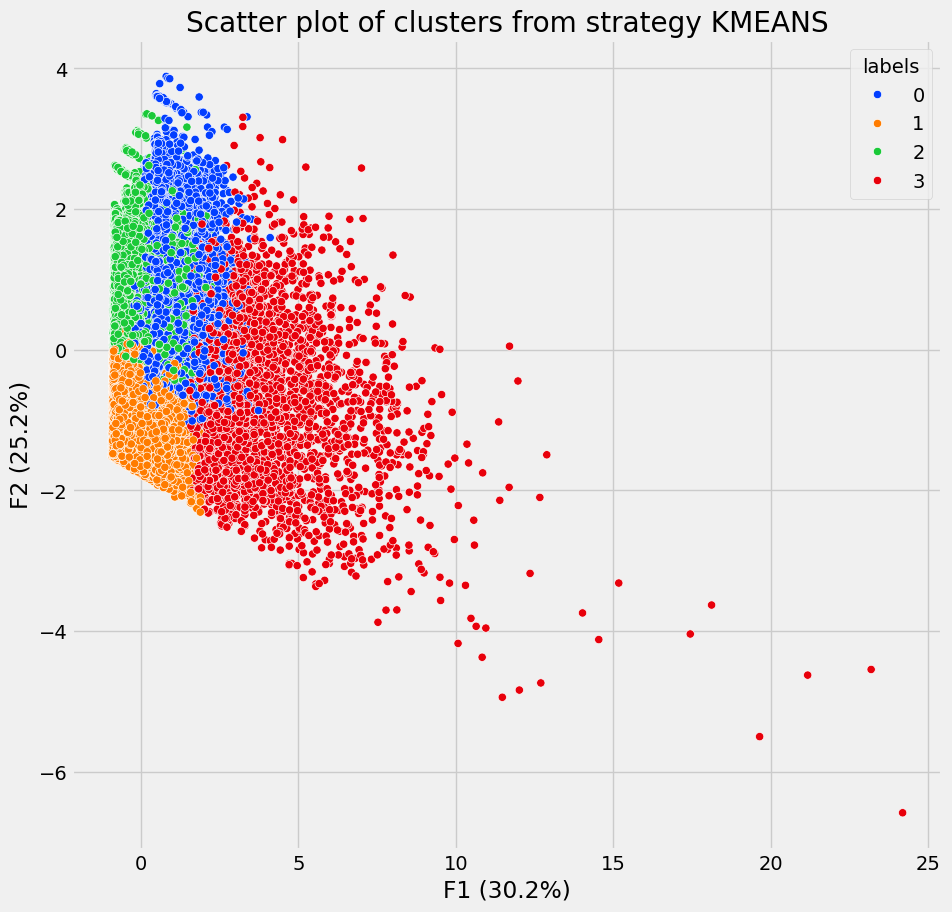

KMeans clustering with 5 clusters started at 13:37:26


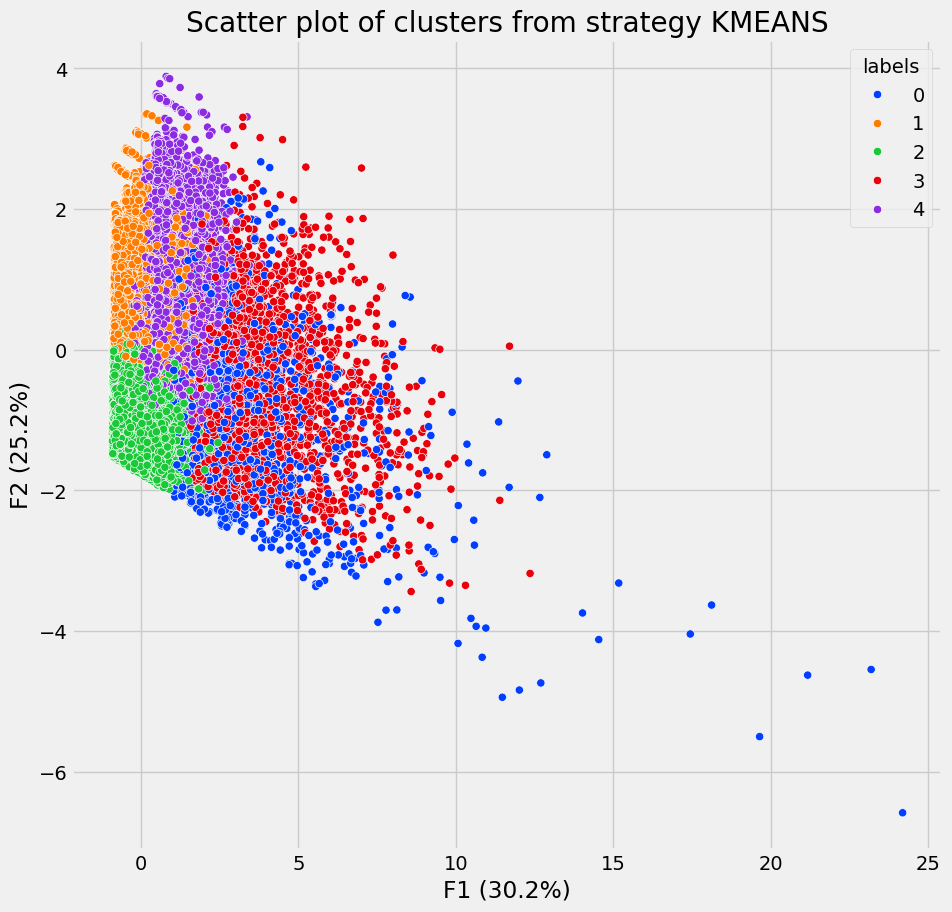

KMeans clustering with 6 clusters started at 13:39:15


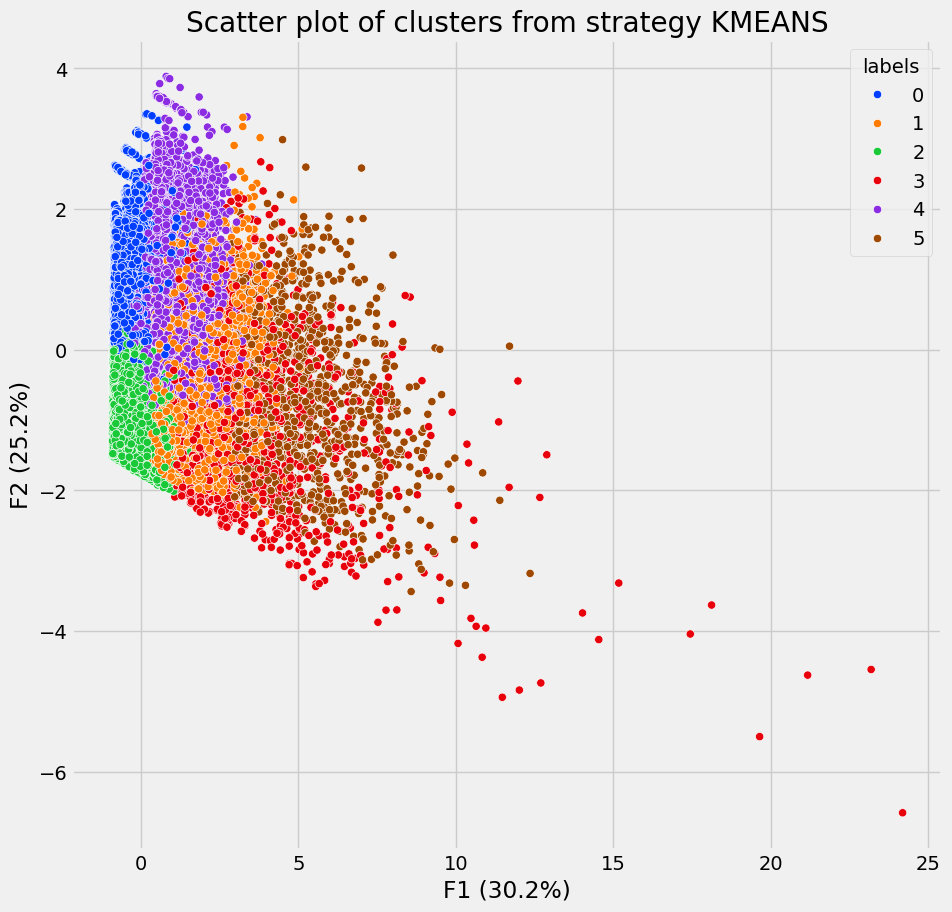

KMeans clustering with 7 clusters started at 13:41:04


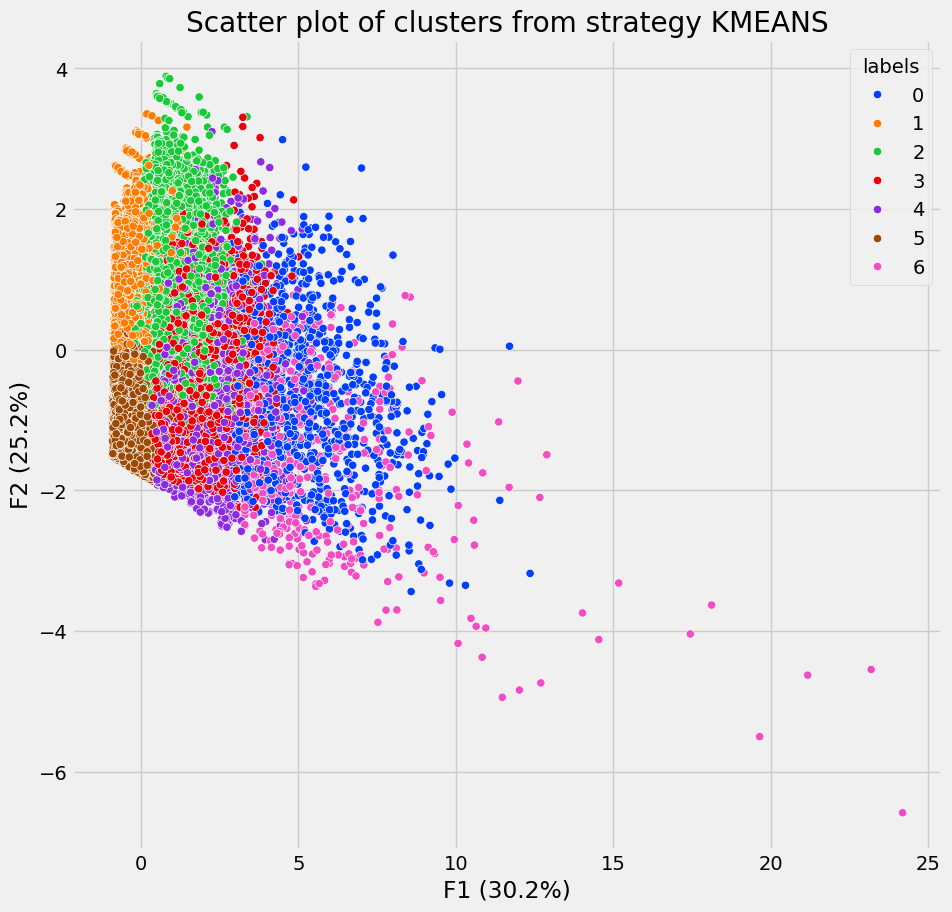

KMeans clustering with 8 clusters started at 13:42:52


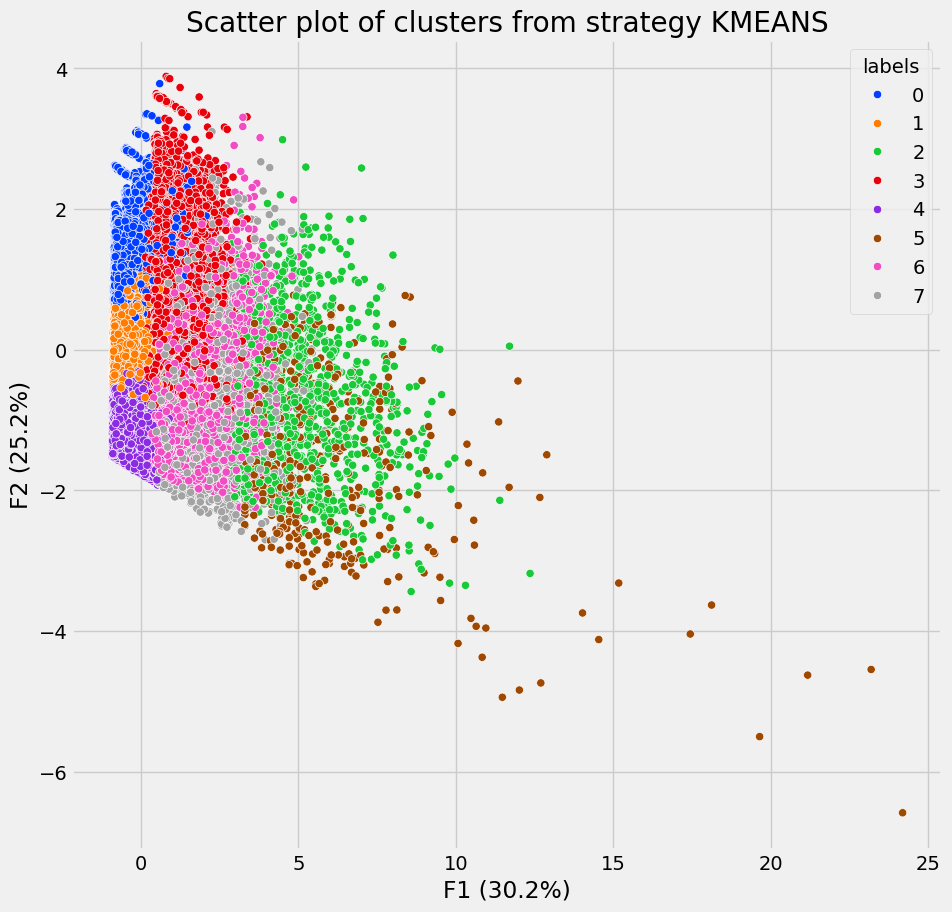

In [ ]:
print("Starting modeling script.\n")

df: DataFrame = load_data()
print("Data loaded.\n")

scaled_df = DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
smaller_scaled_df = scaled_df.sample(n=40000, random_state=42)

kmeans_labels = perform_kmeans_modeling(scaled_df)

perform_density_based_modeling(smaller_scaled_df)

perform_hierarchical_modeling(smaller_scaled_df)

verify_form_and_stability_of_best_strategy(scaled_df, kmeans_labels)

print("All processing is now done.")